In [1]:
import pandas as pd
import numpy as np
import perception.util.conversion as conv
import os
import cv2
import scipy
import math
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

plt.style.use("seaborn-v0_8")

### Import and process BEV and tracking poses

In [59]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
run1_path = f'{experiments_dir}/run1'
run2_path = f'{experiments_dir}/run2'

bev_paths_run1 = [f'{run1_path}/bev/{f}' for f in os.listdir(f'{run1_path}/bev') if os.path.isdir(f'{run1_path}/bev/{f}')]
bev_paths_run2 = [f'{run2_path}/bev/{f}' for f in os.listdir(f'{run2_path}/bev') if os.path.isdir(f'{run2_path}/bev/{f}')]

tracking_paths_run1 = [f'{run1_path}/ego/{f}/color' for f in os.listdir(f'{run1_path}/ego') if os.path.isdir(f'{run1_path}/ego/{f}')]
tracking_paths_run2 = [f'{run2_path}/ego/{f}/color' for f in os.listdir(f'{run2_path}/ego') if os.path.isdir(f'{run2_path}/ego/{f}')]
# bev_path = f'{experiments_dir}/run/bev'
# ego_path = f'{experiments_dir}/50 expo-128 gain/color'
# bev_ego_pose_path = f'{bev_path}/ego_poses.csv'
# tracking_csv_path = f'{ego_path}/opp_rel_poses.csv'

def process_single_run(bev_path, ego_path, window_before_start_time=1, selected_bev_cam="right"):
  start_time = int(np.loadtxt(f'{bev_path}/start_time.txt')) / 1e9
 
  ego_pose_df = process_poses(
    pd.read_csv(f'{bev_path}/bev/{selected_bev_cam}/ego_poses.csv'), start_time, window_before_start_time)

  opp_pose_df = process_poses(
    pd.read_csv(f'{bev_path}/bev/{selected_bev_cam}/opp_poses.csv'), start_time, window_before_start_time)

  tracking_df = process_poses(
    pd.read_csv(f'{ego_path}/opp_rel_poses.csv'), start_time, window_before_start_time)
  
  last_bev_pose_time = max(ego_pose_df["time (sec)"].max(), opp_pose_df["time (sec)"].max())
  # Trim the tracking data to the last BEV pose time
  tracking_df = tracking_df[tracking_df["time (sec)"] <= last_bev_pose_time]

  return ego_pose_df, opp_pose_df, tracking_df

def process_all_runs(bev_paths, ego_paths, window_before_start_time=1):
  bev_run_data = []
  if len(bev_paths) != len(ego_paths):
    raise ValueError("The number of BEV and ego paths should be the same")

  for bev_path, ego_path in zip(bev_paths, ego_paths):
    start_time = int(np.loadtxt(f'{bev_path}/start_time.txt')) / 1e9
    ego_pose_df, opp_pose_df, tracking_df = process_single_run(bev_path, ego_path, window_before_start_time)
    
    bev_run_data.append({
      "start_time": start_time,
      "bev_path": bev_path,
      "ego_path": ego_path,
      "ego_pose_df": ego_pose_df,
      "opp_pose_df": opp_pose_df,
      "tracking_df": tracking_df
    })
  return bev_run_data

def process_poses(poses_df: pd.DataFrame, start_time, window_before_start_time=1):
  poses_df["time (sec)"] = poses_df["time"] / 1e9
  
  # Include a few frames before the trajectory start time
  poses_df_start_time: pd.DataFrame = poses_df[poses_df["time (sec)"] > start_time]
  first_index = poses_df_start_time.index.min()

  if window_before_start_time >= 1:
    poses_df_start_time = pd.concat([poses_df.iloc[first_index - window_before_start_time:first_index], poses_df_start_time])

  poses_df_start_time = poses_df_start_time.reset_index(drop=True)

  # normalise the time from df to start at 0
  poses_df_start_time['time_norm (sec)'] = (poses_df_start_time['time (sec)'] - start_time)

  return poses_df_start_time

run1_data = process_all_runs(bev_paths_run1, tracking_paths_run1)
run2_data = process_all_runs(bev_paths_run2, tracking_paths_run2)

In [60]:
# TODO: Add uncertainty to these measurements
BEV_TO_BACK_OPP_X = -100.0
BEV_TO_BACK_OPP_Y = 0.0
BEV_TO_BACK_OPP_Z = -120.0

BEV_TO_CAM_EGO_X = -184.8
BEV_TO_CAM_EGO_Y = -39.5
BEV_TO_CAM_EGO_Z = 12.5

### Analyze single run for now

In [61]:
run_num = 7

combined_df = pd.concat([run1_data[run_num]["ego_pose_df"], run1_data[run_num]["opp_pose_df"]], axis=1, keys=['ego', 'opp'])
# Drop rows with NaN values in any of the columns
combined_cleaned = combined_df.dropna().reset_index(drop=True)

ego_bev_df = combined_cleaned['ego']
opp_bev_df = combined_cleaned['opp']

tracking_df: pd.DataFrame = run1_data[run_num]["tracking_df"].dropna().reset_index(drop=True)

In [62]:
ego_bev_df

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec)
0,1726384502785766956,0.961590,0.274382,0.003262,0.006950,3.007632,0.858202,0.010202,1.350783,1.123419,2.947871,1.726385e+09,-0.013628
1,1726384502800483308,0.962539,0.270886,-0.009032,0.007601,3.009359,0.846919,-0.028240,1.359397,1.130045,2.966012,1.726385e+09,0.001088
2,1726384502816710353,0.962484,0.270819,-0.013278,0.010301,3.004061,0.845268,-0.041442,1.362714,1.132672,2.973147,1.726385e+09,0.017316
3,1726384502833403957,0.962250,0.272039,-0.004449,0.006987,3.009626,0.850857,-0.013917,1.355276,1.126894,2.957161,1.726385e+09,0.034009
4,1726384502850173537,0.962091,0.272583,-0.003367,0.008219,3.006786,0.851893,-0.010524,1.353812,1.125892,2.954504,1.726385e+09,0.050779
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,1726384508334112875,-0.999828,0.018251,0.003321,0.000613,-3.139827,0.057314,0.010428,-0.860622,0.925751,2.967056,1.726385e+09,5.534718
322,1726384508350660162,-0.999842,0.015401,-0.008532,0.002611,-3.135885,0.048303,-0.026759,-0.862447,0.927022,2.972126,1.726385e+09,5.551265
323,1726384508368223472,0.999415,-0.026442,-0.018928,0.010577,3.118788,-0.082515,-0.059066,-0.861645,0.924209,2.965081,1.726385e+09,5.568829
324,1726384508384839112,-0.999860,0.016390,-0.003050,0.001375,-3.138406,0.051445,-0.009573,-0.861689,0.926365,2.969629,1.726385e+09,5.585444


In [63]:
ego_bev_df.head()

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec)
0,1726384502785766956,0.961590,0.274382,0.003262,0.006950,3.007632,0.858202,0.010202,1.350783,1.123419,2.947871,1.726385e+09,-0.013628
1,1726384502800483308,0.962539,0.270886,-0.009032,0.007601,3.009359,0.846919,-0.028240,1.359397,1.130045,2.966012,1.726385e+09,0.001088
2,1726384502816710353,0.962484,0.270819,-0.013278,0.010301,3.004061,0.845268,-0.041442,1.362714,1.132672,2.973147,1.726385e+09,0.017316
3,1726384502833403957,0.962250,0.272039,-0.004449,0.006987,3.009626,0.850857,-0.013917,1.355276,1.126894,2.957161,1.726385e+09,0.034009
4,1726384502850173537,0.962091,0.272583,-0.003367,0.008219,3.006786,0.851893,-0.010524,1.353812,1.125892,2.954504,1.726385e+09,0.050779


### Test difference with pose estimation on distorted and undistorted images

In [64]:
side_length = 0.15
half_side_length = side_length / 2

# Define the 4 corners of the ArUco marker
marker_obj_points = np.array([[
    [-half_side_length, half_side_length, 0],
    [half_side_length, half_side_length, 0],
    [half_side_length, -half_side_length, 0],
    [-half_side_length, -half_side_length, 0]
]], dtype=np.float32)

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX

(array([[1.44603966],
        [1.08844077],
        [2.93652588]]),
 (-179.16827183986018, 1.0943357116704828, 30.755713188304476),
 array([[1.44419423],
        [1.08695973],
        [2.93380379]]),
 (-177.96907495324257, -0.886189552756832, 31.849526965060225),
 array([[1.44419864],
        [1.08696278],
        [2.93381277]]),
 (-177.96912050622188, -0.8857461911180744, 31.849676763687736))

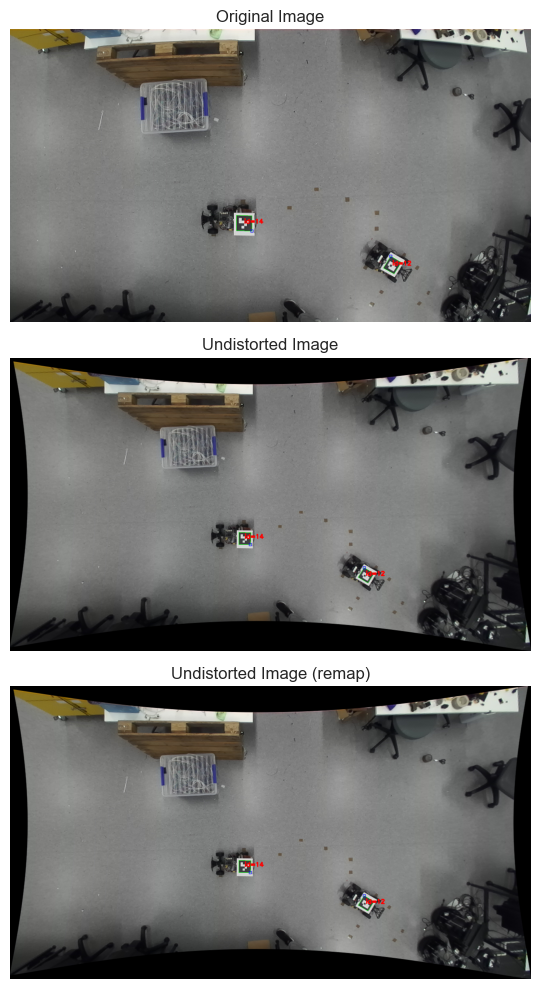

In [65]:
image = cv2.imread(f'{run1_path}/bev/24_09_15_18:50:11/bev/left/1726383014030341577.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

intrinsics = np.loadtxt(f'{run1_path}/bev/24_09_15_18:50:11/bev/left/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run1_path}/bev/24_09_15_18:50:11/bev/left/dist_coeffs.txt')

new_img_size = (int(image.shape[1] * 1.2), int(image.shape[0] * 1.2))
# not specifying new image size
new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)

# specifying new image size
new_intrinsics2, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
mapx, mapy = cv2.initUndistortRectifyMap(intrinsics, dist_coeffs, None, new_intrinsics, image.shape[:2][::-1], m1type=cv2.CV_32FC1)
undistorted_image2 = cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)

und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)
und2_corners, und2_ids, _ = cv2.aruco.detectMarkers(undistorted_image2, dictionary, parameters=detector_params)
corners, ids, _ = cv2.aruco.detectMarkers(image, cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50), parameters=detector_params)

_, rvec_und, tvec_und = cv2.solvePnP(marker_obj_points, und_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und), degrees=True)

_, rvec_und2, tvec_und2 = cv2.solvePnP(marker_obj_points, und2_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und2 = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und2), degrees=True)

_, rvec, tvec = cv2.solvePnP(marker_obj_points, corners[1], intrinsics, dist_coeffs,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec), degrees=True)

image_draw = cv2.aruco.drawDetectedMarkers(image.copy(), corners, ids)
und_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)
und2_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image2.copy(), und2_corners, und2_ids)

plt.figure(figsize=(6, 10))
plt.subplot(3, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(image_draw)
plt.title("Original Image")
plt.subplot(3, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(und_image_draw)
plt.title("Undistorted Image")
plt.subplot(3, 1, 3)
plt.grid(False)
plt.axis('off')
plt.imshow(und2_image_draw)
plt.title("Undistorted Image (remap)")
plt.tight_layout()

tvec, euler, tvec_und, euler_und, tvec_und2, euler_und2

### Sanity checking conversions

In [66]:
rvec = ego_bev_df[["ax", "ay", "az"]].values[0]
quat = conv.get_quaternion_from_rodrigues(rvec)

rvec, conv.get_quaternion_from_rodrigues(rvec), \
conv.get_rotation_matrix_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec)), cv2.Rodrigues(rvec)[0], \
conv.get_euler_from_quaternion(*quat), \
conv.get_euler_from_rotation_matrix(conv.get_rotation_matrix_from_quaternion(*quat))

(array([3.00763163, 0.85820209, 0.0102017 ]),
 array([0.96159025, 0.27438159, 0.00326166, 0.00694982]),
 array([[ 0.8494082 ,  0.52764   ,  0.01008656],
        [ 0.52773067, -0.84933288, -0.01157587],
        [ 0.00245895,  0.01515563, -0.99988212]]),
 array([[ 0.8494082 ,  0.52764   ,  0.01008656],
        [ 0.52773067, -0.84933288, -0.01157587],
        [ 0.00245895,  0.01515563, -0.99988212]]),
 (3.1264364001566607, -0.0024589519291482453, 0.5559285667648617),
 (3.1264364001566607, -0.0024589519291482453, 0.5559285667648617))

### Generate positive Euler angles following XYZ extrinsic convention

In [67]:
def stabilise_euler_angles(df: pd.DataFrame) -> pd.DataFrame:
  """
  Stabilise the Euler angles by ensuring that the difference 
  between consecutive angles is less than 180 degrees
  """
  for i, row in df.iterrows():
    if i == 0:
      continue
    prev_roll, prev_pitch, prev_yaw = df.loc[i - 1, ["roll", "pitch", "yaw"]]
    roll, pitch, yaw = row[["roll", "pitch", "yaw"]]

    if abs(prev_roll - roll) > 180:
      df.loc[i, "roll"] = (roll + 360 * np.sign(prev_roll - roll)) % 360
    if abs(prev_pitch - pitch) > 180:
      df.loc[i, "pitch"] = (pitch + 360 * np.sign(prev_pitch - pitch)) % 360
    if abs(prev_yaw - yaw) > 180:
      df.loc[i, "yaw"] = (yaw + 360 * np.sign(prev_yaw - yaw)) % 360

  def find_closest_equiv_angle(alpha, beta):
    """
    Find the equivalent angle to alpha that is closest to beta
    """
    diff = beta - alpha
    if diff > 180:
      return alpha + 360
    elif diff < -180:
      return alpha - 360
    return alpha
  # lowest_diff = float("inf")
  # angle = df.loc[0, "roll"]
  # for i in range(-360, 361, 360):
  #   diff = abs(df.loc[1, "roll"], df.loc[0, "roll"] + i)
  #   if diff < lowest_diff:
  #     lowest_diff = diff
  #     angle = df.loc[0, "roll"] + i
  df.loc[0, "roll"] = find_closest_equiv_angle(df.loc[0, "roll"], df.loc[1, "roll"])
  df.loc[0, "pitch"] = find_closest_equiv_angle(df.loc[0, "pitch"], df.loc[1, "pitch"])
  df.loc[0, "yaw"] = find_closest_equiv_angle(df.loc[0, "yaw"], df.loc[1, "yaw"])
  return df

In [68]:
ego_bev_df['roll'], ego_bev_df['pitch'], ego_bev_df['yaw'] = \
  zip(*ego_bev_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))
opp_bev_df['roll'], opp_bev_df['pitch'], opp_bev_df['yaw'] = \
  zip(*opp_bev_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))
tracking_df['roll'], tracking_df['pitch'], tracking_df['yaw'] = \
  zip(*tracking_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))

ego_bev_df = stabilise_euler_angles(ego_bev_df)
opp_bev_df = stabilise_euler_angles(opp_bev_df)
tracking_df = stabilise_euler_angles(tracking_df)

/tmp/ipykernel_11297/2456672411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ego_bev_df['roll'], ego_bev_df['pitch'], ego_bev_df['yaw'] = \
/tmp/ipykernel_11297/2456672411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ego_bev_df['roll'], ego_bev_df['pitch'], ego_bev_df['yaw'] = \
/tmp/ipykernel_11297/2456672411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [69]:
# Make assumption that the top marker and the camera on the egovehicle have fixed relative orientation
EGO_TOP_MARKER_TO_EGO_CAM_QUAT = np.array([-0.5, -0.5, 0.5, 0.5])

### Get ground truth position of relative translation between egovehicle camera and opponent back marker

In [70]:
ego_bev_df

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
0,1726384502785766956,0.961590,0.274382,0.003262,0.006950,3.007632,0.858202,0.010202,1.350783,1.123419,2.947871,1.726385e+09,-0.013628,179.131611,-0.140888,31.852361
1,1726384502800483308,0.962539,0.270886,-0.009032,0.007601,3.009359,0.846919,-0.028240,1.359397,1.130045,2.966012,1.726385e+09,0.001088,179.441820,1.232309,31.430202
2,1726384502816710353,0.962484,0.270819,-0.013278,0.010301,3.004061,0.845268,-0.041442,1.362714,1.132672,2.973147,1.726385e+09,0.017316,179.275556,1.784419,31.419276
3,1726384502833403957,0.962250,0.272039,-0.004449,0.006987,3.009626,0.850857,-0.013917,1.355276,1.126894,2.957161,1.726385e+09,0.034009,179.368228,0.708448,31.568534
4,1726384502850173537,0.962091,0.272583,-0.003367,0.008219,3.006786,0.851893,-0.010524,1.353812,1.125892,2.954504,1.726385e+09,0.050779,179.199036,0.627963,31.632934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,1726384508334112875,-0.999828,0.018251,0.003321,0.000613,-3.139827,0.057314,0.010428,-0.860622,0.925751,2.967056,1.726385e+09,5.534718,180.063232,0.381734,-2.091295
322,1726384508350660162,-0.999842,0.015401,-0.008532,0.002611,-3.135885,0.048303,-0.026759,-0.862447,0.927022,2.972126,1.726385e+09,5.551265,180.314206,-0.972944,-1.767604
323,1726384508368223472,0.999415,-0.026442,-0.018928,0.010577,3.118788,-0.082515,-0.059066,-0.861645,0.924209,2.965081,1.726385e+09,5.568829,178.730373,2.136145,-3.054743
324,1726384508384839112,-0.999860,0.016390,-0.003050,0.001375,-3.138406,0.051445,-0.009573,-0.861689,0.926365,2.969629,1.726385e+09,5.585444,180.163292,-0.346864,-1.878734


In [71]:
num = 50

ego_top_marker_to_bev_rvec = ego_bev_df.iloc[num][["ax", "ay", "az"]].to_numpy()
ego_top_marker_in_bev_frame = ego_bev_df.iloc[num][["tx", "ty", "tz"]].to_numpy()

opp_top_marker_to_bev_rvec = opp_bev_df.iloc[num][["ax", "ay", "az"]].to_numpy()
opp_top_marker_in_bev_frame = opp_bev_df.iloc[num][["tx", "ty", "tz"]].to_numpy()

def get_ego_cam_from_top_marker(rvec, tvec):
  """
  Get the position of the ego camera in the BEV camera frame
  """
  ego_cam_in_ego_top_marker_frame = np.array([BEV_TO_CAM_EGO_X, BEV_TO_CAM_EGO_Y, BEV_TO_CAM_EGO_Z]) / 1000
  ego_top_marker_to_ego_cam_rot = cv2.Rodrigues(rvec)[0]

  ego_cam_in_ego_top_marker_frame_rot_to_ego_cam = ego_top_marker_to_ego_cam_rot @ ego_cam_in_ego_top_marker_frame
  ego_top_marker_in_ego_cam_frame = tvec

  ego_cam_in_ego_cam_frame = ego_top_marker_in_ego_cam_frame + ego_cam_in_ego_top_marker_frame_rot_to_ego_cam
  return ego_cam_in_ego_cam_frame

def get_opp_back_from_top_marker(rvec, tvec):
  """
  Get the position of the opponent back marker in the BEV camera frame
  """
  opp_back_in_opp_top_marker_frame = np.array([BEV_TO_BACK_OPP_X, BEV_TO_BACK_OPP_Y, BEV_TO_BACK_OPP_Z]) / 1000
  opp_top_marker_to_opp_back_rot = cv2.Rodrigues(rvec)[0]

  opp_back_in_opp_top_marker_frame_rot_to_opp_back = opp_top_marker_to_opp_back_rot @ opp_back_in_opp_top_marker_frame
  opp_top_marker_in_opp_back_frame = tvec

  opp_back_in_opp_back_frame = opp_top_marker_in_opp_back_frame + opp_back_in_opp_top_marker_frame_rot_to_opp_back
  return opp_back_in_opp_back_frame

def rotate_bev_frame_to_ego_cam_frame(rvec, tvec):
  """
  Rotate the pose vector in the BEV frame to the ego camera frame
  """
  bev_to_ego_top_marker_rot = cv2.Rodrigues(rvec)[0].T
  
  return conv.get_rotation_matrix_from_quaternion(*EGO_TOP_MARKER_TO_EGO_CAM_QUAT).T @ bev_to_ego_top_marker_rot @ tvec

# Get position of ego camera in BEV frame
ego_cam_in_bev_frame = get_ego_cam_from_top_marker(ego_top_marker_to_bev_rvec, ego_top_marker_in_bev_frame)
# Get position of opponent back marker in BEV frame
opp_back_in_bev_frame = get_opp_back_from_top_marker(opp_top_marker_to_bev_rvec, opp_top_marker_in_bev_frame)

# Get the relative pose of the opponent back marker in the BEV camera frame
ground_truth_rel_pose_bev_frame = opp_back_in_bev_frame - ego_cam_in_bev_frame
# Convert the relative pose to the ego camera frame
print(ground_truth_rel_pose_bev_frame)
ground_truth_rel_pose_ego_cam_frame = rotate_bev_frame_to_ego_cam_frame(ego_top_marker_to_bev_rvec, ground_truth_rel_pose_bev_frame)

ground_truth_rel_pose_ego_cam_frame

[-1.4148242  -0.42471542 -0.23274802]


array([-0.2046834 , -0.43683688,  1.41547186])

In [109]:
from scipy.signal import savgol_filter

### apply exponential smoothing to the tracking data
# ego_bev_df['ty'].ewm(span=5).mean().plot()

def apply_rolling_mean(df: pd.DataFrame, src: str, dest: str, window=20, center=True):
  df.loc[:, dest] = df[src].rolling(window=window, center=center).mean()

def apply_savgol_filter(df: pd.DataFrame, src: str, dest: str, window=20, polyorder=5):
  df.loc[:, dest] = savgol_filter(df[src], window, polyorder)

columns = ["tx", "ty", "tz", "roll", "pitch", "yaw"]

for col in columns:
  apply_rolling_mean(ego_bev_df, col, f"{col} (rolling)")
  apply_savgol_filter(ego_bev_df, col, f"{col} (savgol)", polyorder=2)

  apply_rolling_mean(opp_bev_df, col, f"{col} (rolling)")
  apply_savgol_filter(opp_bev_df, col, f"{col} (savgol)", polyorder=2)

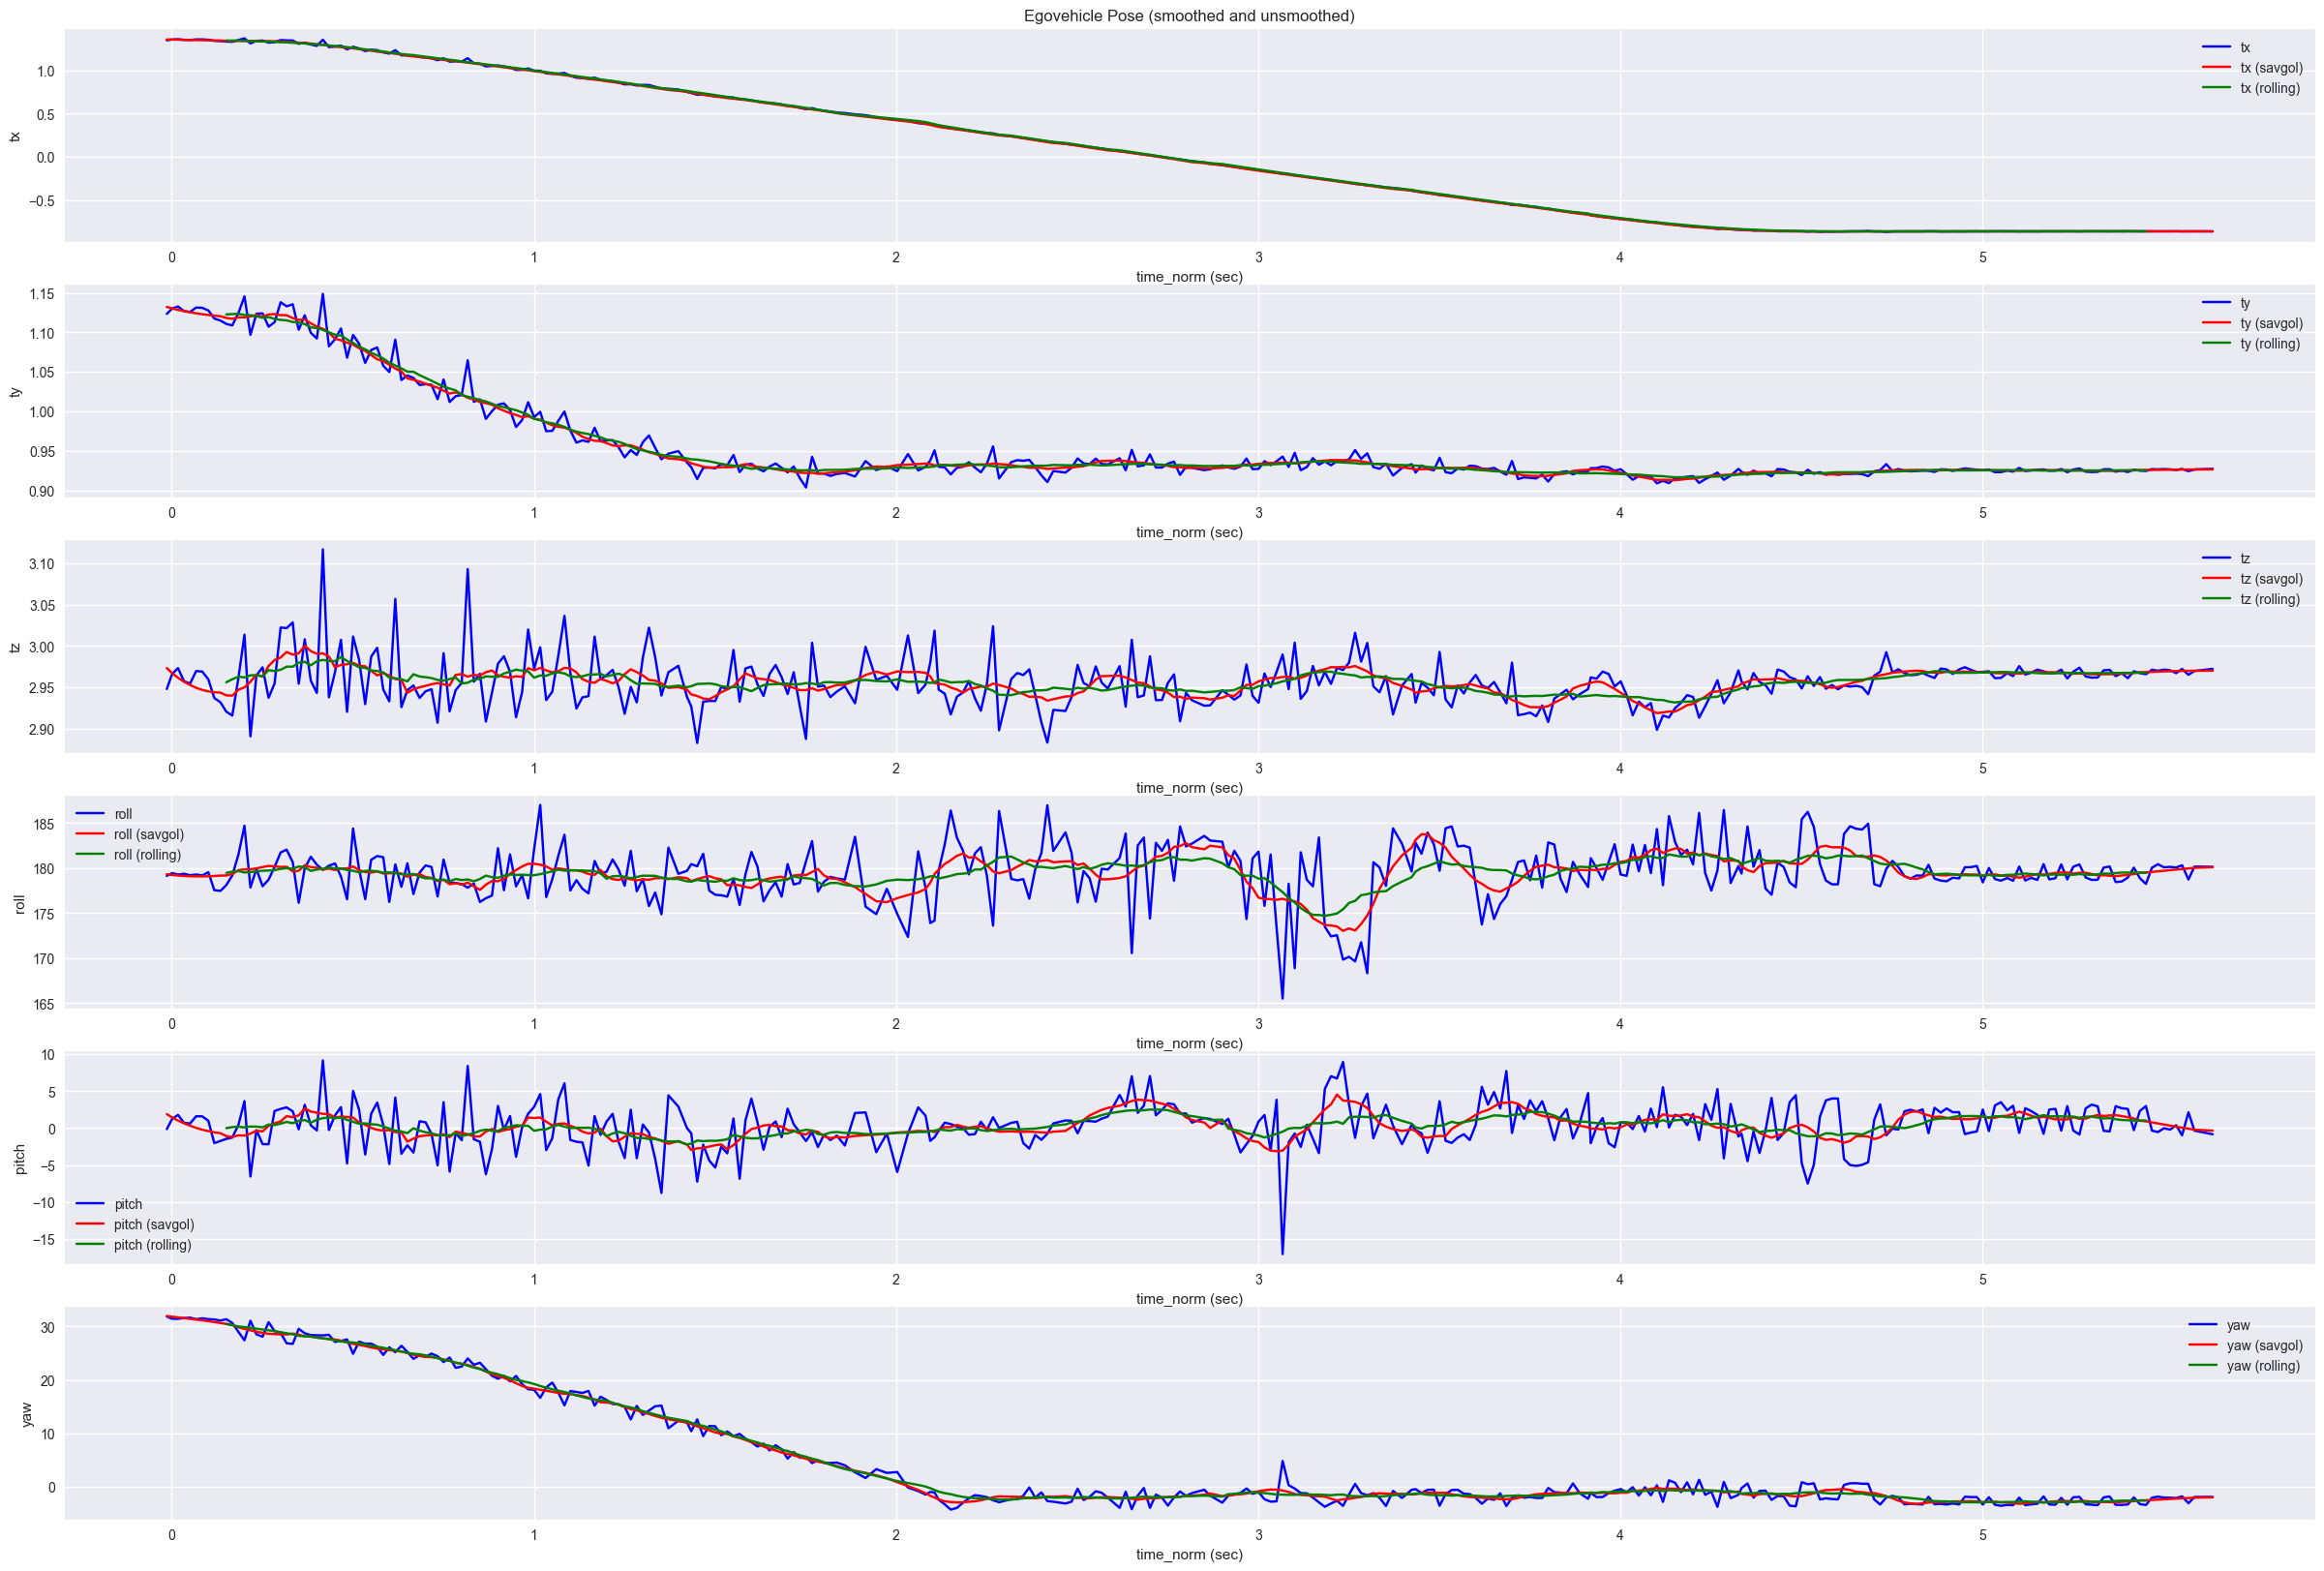

In [110]:
# plot the x and y positions
plt.figure(figsize=(30, 20))

def plot_smoothed_data(df: pd.DataFrame, x_col: str, y_col: str):
  sns.lineplot(data=df, x=x_col, y=y_col, label=y_col, color='blue')
  sns.lineplot(data=df, x=x_col, y=f"{y_col} (savgol)", label=f"{y_col} (savgol)", color='red')
  sns.lineplot(data=df, x=x_col, y=f"{y_col} (rolling)", label=f"{y_col} (rolling)", color='green')

plt.subplot(6, 1, 1)
plt.title('Egovehicle Pose (smoothed and unsmoothed)')
plot_smoothed_data(ego_bev_df, "time_norm (sec)", "tx")
plt.subplot(6, 1, 2)
plot_smoothed_data(ego_bev_df, "time_norm (sec)", "ty")
plt.subplot(6, 1, 3)
plot_smoothed_data(ego_bev_df, "time_norm (sec)", "tz")

plt.subplot(6, 1, 4)
plot_smoothed_data(ego_bev_df, "time_norm (sec)", "roll")
plt.subplot(6, 1, 5)
plot_smoothed_data(ego_bev_df, "time_norm (sec)", "pitch")
plt.subplot(6, 1, 6)
plot_smoothed_data(ego_bev_df, "time_norm (sec)", "yaw")

In [17]:
def compute_relative_pose(ego_bev_df: pd.DataFrame, opp_bev_df: pd.DataFrame):
  rel_poses = pd.DataFrame(columns=["time (sec)", "time_norm (sec)", "rel_x", "rel_y", "rel_z", "rel_roll", "rel_pitch", "rel_yaw"])

  for i in range(len(ego_bev_df)):
    ego_top_marker_to_bev_rvec = ego_bev_df.iloc[i][["ax", "ay", "az"]].to_numpy()
    ego_top_marker_in_bev_frame = ego_bev_df.iloc[i][["tx", "ty", "tz"]].to_numpy()

    opp_top_marker_to_bev_rvec = opp_bev_df.iloc[i][["ax", "ay", "az"]].to_numpy()
    opp_top_marker_in_bev_frame = opp_bev_df.iloc[i][["tx", "ty", "tz"]].to_numpy()
   
    ego_cam_in_bev_frame = get_ego_cam_from_top_marker(ego_top_marker_to_bev_rvec, ego_top_marker_in_bev_frame)
    opp_back_in_bev_frame = get_opp_back_from_top_marker(opp_top_marker_to_bev_rvec, opp_top_marker_in_bev_frame)

    ground_truth_rel_pose_bev_frame = opp_back_in_bev_frame - ego_cam_in_bev_frame
    ground_truth_rel_pose_ego_cam_frame = rotate_bev_frame_to_ego_cam_frame(ego_top_marker_to_bev_rvec, ground_truth_rel_pose_bev_frame)
    if i == 50:
      print(ego_bev_df.iloc[i]["time"], ego_top_marker_to_bev_rvec, ego_top_marker_in_bev_frame)
      print(opp_top_marker_to_bev_rvec, opp_top_marker_in_bev_frame)
      print(ground_truth_rel_pose_ego_cam_frame)
    rel_poses = pd.concat([rel_poses, pd.DataFrame([{
      "time (sec)": ego_bev_df.loc[i, "time (sec)"],
      "time_norm (sec)": ego_bev_df.loc[i, "time_norm (sec)"],
      "rel_x": ground_truth_rel_pose_ego_cam_frame[0],
      "rel_y": ground_truth_rel_pose_ego_cam_frame[1],
      "rel_z": ground_truth_rel_pose_ego_cam_frame[2],
    }])])

  return rel_poses

rel_pose_ground_truth_df = compute_relative_pose(ego_bev_df, opp_bev_df)

1.7263845036167076e+18 [ 2.99892557  0.64230962 -0.20816837] [1.14306523 1.06467114 3.09297886]
[ 0.06298423 -3.040172    0.18166779] [-0.56705391  0.58229504  2.76452959]
[-0.2046834  -0.43683688  1.41547186]


In [20]:
tracking_df.describe()

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
count,1.420000e+02,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,1.420000e+02,142.000000,142.000000,142.000000,142.000000
mean,1.726385e+18,-0.138550,-0.140980,0.085188,0.098334,-0.415354,-0.422745,0.249425,0.256189,-0.046089,1.330357,1.726385e+09,2.342941,182.173333,-0.113085,90.424965
std,1.372201e+09,0.684909,0.691074,0.048721,0.040507,2.028401,2.046378,0.139469,0.288158,0.005214,0.029775,1.372201e+00,1.372201,16.407213,2.428775,0.617271
min,1.726385e+18,-0.706214,-0.709245,-0.048572,0.001943,-2.215577,-2.218459,-0.152406,-0.275915,-0.057671,1.290741,1.726385e+09,-0.009018,149.162727,-7.856789,88.461399
25%,1.726385e+18,-0.698445,-0.705695,0.063970,0.083076,-2.069101,-2.093506,0.192880,-0.012464,-0.048969,1.305999,1.726385e+09,1.167120,168.028171,-1.790849,90.099143
50%,1.726385e+18,-0.694547,-0.703111,0.079153,0.097060,-2.035747,-2.059342,0.236460,0.452122,-0.046793,1.316018,1.726385e+09,2.342954,192.361524,-0.123467,90.321439
75%,1.726385e+18,0.692144,0.697741,0.110867,0.118479,2.003484,2.021883,0.327790,0.478201,-0.042379,1.361548,1.726385e+09,3.518792,194.860528,1.456606,90.755041
max,1.726385e+18,0.707181,0.709501,0.193140,0.183372,2.213956,2.218192,0.546643,0.510308,-0.033861,1.383793,1.726385e+09,4.694636,200.977597,4.380010,92.307660


<AxesSubplot: xlabel='time_norm (sec)', ylabel='rel_z'>

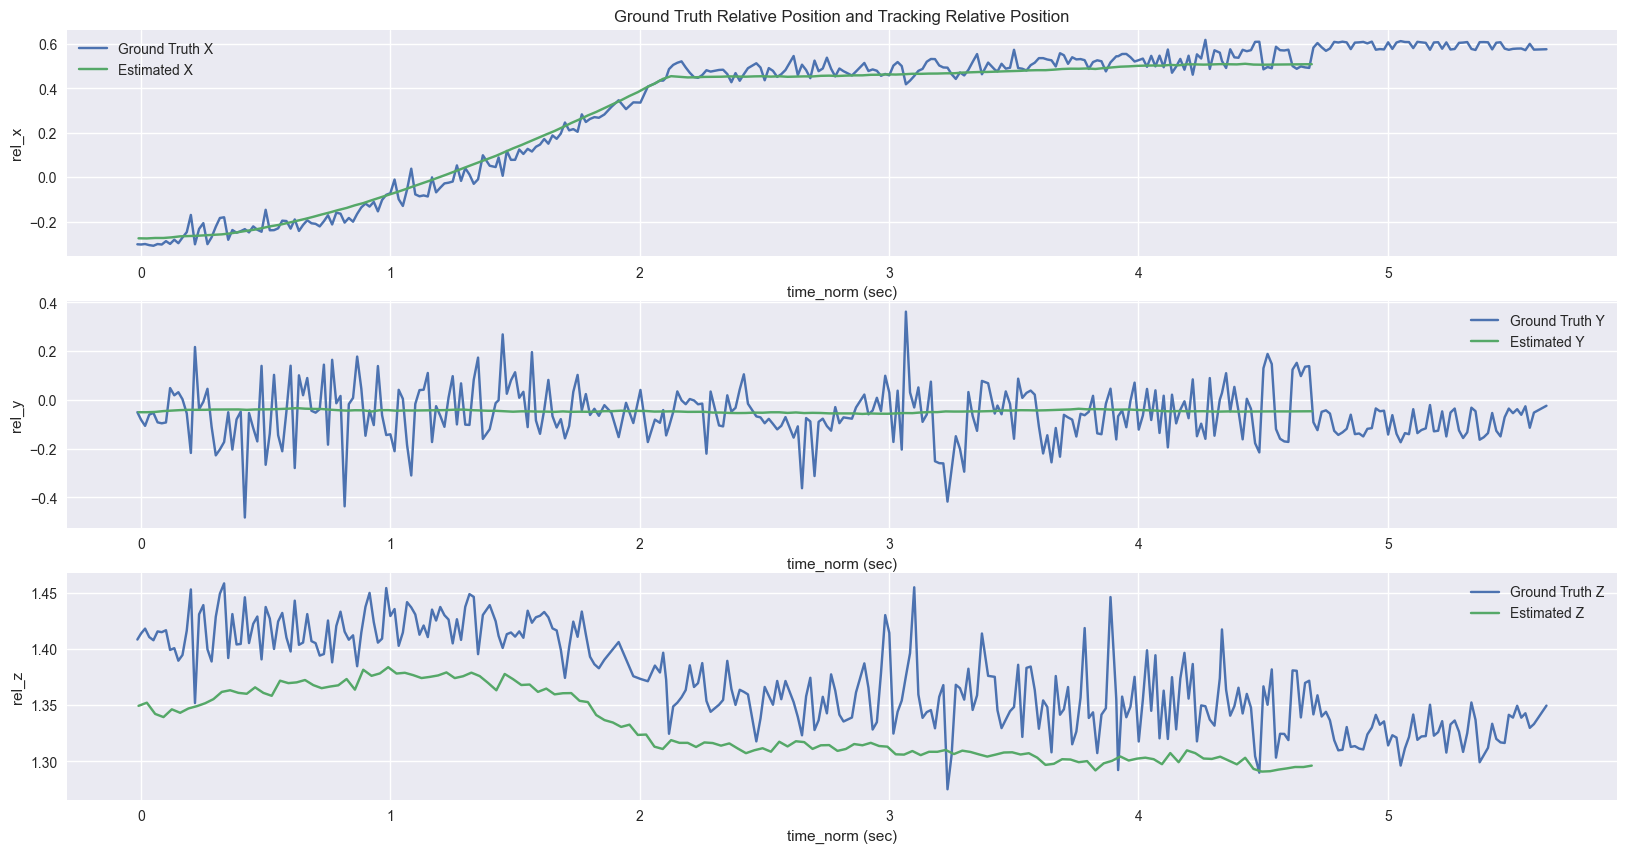

In [21]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title("Ground Truth Relative Position and Tracking Relative Position")

sns.lineplot(x="time_norm (sec)", y="rel_x", data=rel_pose_ground_truth_df, label="Ground Truth X")
sns.lineplot(x="time_norm (sec)", y="tx", data=tracking_df, label="Estimated X")

plt.subplot(3, 1, 2)
sns.lineplot(x="time_norm (sec)", y="rel_y", data=rel_pose_ground_truth_df, label="Ground Truth Y")
sns.lineplot(x="time_norm (sec)", y="ty", data=tracking_df, label="Estimated Y")

plt.subplot(3, 1, 3)
sns.lineplot(x="time_norm (sec)", y="rel_z", data=rel_pose_ground_truth_df, label="Ground Truth Z")
sns.lineplot(x="time_norm (sec)", y="tz", data=tracking_df, label="Estimated Z")


In [72]:
from numpy.polynomial.polynomial import Polynomial

def fit_model(df: pd.DataFrame, x_col: str, y_col: str, degree=1, confidence_interval=0.95):
  model: Polynomial = Polynomial.fit(df[x_col], df[y_col], degree)
  preds = model(df[x_col])
  residuals = df[y_col] - preds
  se = np.sqrt(sum(residuals ** 2) / (len(residuals) - degree - 1))
  z_score = stats.norm.ppf(1 - (1 - confidence_interval) / 2)
  confidence = z_score * se

  return model, residuals, confidence

degree = 10
CONFIDENCE_INTERVAL = 0.95

tx_model, _, tx_confidence = fit_model(ego_bev_df, "time_norm (sec)", "tx", degree, CONFIDENCE_INTERVAL)
ty_model, _, ty_confidence = fit_model(ego_bev_df, "time_norm (sec)", "ty", degree, CONFIDENCE_INTERVAL)
tz_model, _, tz_confidence = fit_model(ego_bev_df, "time_norm (sec)", "tz", degree, CONFIDENCE_INTERVAL)

rel_x_model, _, rel_x_confidence = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_x", degree, CONFIDENCE_INTERVAL)
rel_y_model, _, rel_y_confidence = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_y", 1, CONFIDENCE_INTERVAL)
rel_z_model, _, rel_z_confidence = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_z", degree, CONFIDENCE_INTERVAL)

In [14]:
rel_pose = tracking_df.iloc[1][["tx", "ty", "tz"]].to_numpy()
rel_pose

array([-0.27591544, -0.0507072 ,  1.352142  ])

In [16]:
ego_bev_df.head()

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
0,1726384502785766956,0.961590,0.274382,0.003262,0.006950,3.007632,0.858202,0.010202,1.350783,1.123419,2.947871,1.726385e+09,-0.013628,179.131611,-0.140888,31.852361
1,1726384502800483308,0.962539,0.270886,-0.009032,0.007601,3.009359,0.846919,-0.028240,1.359397,1.130045,2.966012,1.726385e+09,0.001088,179.441820,1.232309,31.430202
2,1726384502816710353,0.962484,0.270819,-0.013278,0.010301,3.004061,0.845268,-0.041442,1.362714,1.132672,2.973147,1.726385e+09,0.017316,179.275556,1.784419,31.419276
3,1726384502833403957,0.962250,0.272039,-0.004449,0.006987,3.009626,0.850857,-0.013917,1.355276,1.126894,2.957161,1.726385e+09,0.034009,179.368228,0.708448,31.568534
4,1726384502850173537,0.962091,0.272583,-0.003367,0.008219,3.006786,0.851893,-0.010524,1.353812,1.125892,2.954504,1.726385e+09,0.050779,179.199036,0.627963,31.632934


In [17]:
opp_bev_df.head()

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
0,1726384502785766956,-0.012182,0.998614,0.029490,0.041860,-0.037285,3.056288,0.090256,-0.271886,0.577152,2.747827,1.726385e+09,-0.013628,176.670038,4.837079,-178.742819
1,1726384502800483308,-0.014928,0.998952,-0.009632,0.042190,-0.045679,3.056705,-0.029472,-0.273845,0.581987,2.775125,1.726385e+09,0.001088,181.178986,4.818696,-178.238094
2,1726384502816710353,-0.014922,0.998935,-0.003369,0.043521,-0.045623,3.054165,-0.010299,-0.273724,0.581136,2.771453,1.726385e+09,0.017316,180.461759,4.982370,-178.268272
3,1726384502833403957,-0.006311,0.998857,-0.003947,0.047223,-0.019252,3.047027,-0.012040,-0.273463,0.582750,2.771149,1.726385e+09,0.034009,180.488106,5.410334,-179.252913
4,1726384502850173537,-0.014426,0.998860,-0.007106,0.044954,-0.044068,3.051259,-0.021708,-0.273738,0.581570,2.772581,1.726385e+09,0.050779,180.891339,5.140591,-178.305125


In [18]:
ego_bev_df.iloc[num]['time']

1.7263845028167104e+18

In [19]:
run1_data[run_num]["bev_path"]

'/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/../../../../perception_debug/run1/bev/24_09_15_19:14:57'

[14] (-179.71281351074762, 2.458595967695903, -169.85645036179432) [[-2.73744360e-01]
 [ 3.08629021e+00]
 [-1.85703269e-03]] [-8.83294338e-02  9.95857107e-01 -5.99211051e-04  2.15910911e-02]
[14] (-134.68969626954555, 55.96906880913935, -145.39127304892753) [[-0.16783491]
 [ 1.99894285]
 [-0.47088507]] [-0.06984043  0.83181163 -0.19594741  0.51460309]

[12] (158.43355259893164, 9.813781746981347, -3.805198788224907) [[ 2.76038926]
 [-0.04653657]
 [-0.25430944]] [ 0.97873356 -0.01650017 -0.09016887  0.18351551]
[12] (165.50286128404443, -17.030486628259034, 4.854473684848058) [[2.86910695]
 [0.06692603]
 [0.44468096]] [0.98098373 0.02288285 0.15204201 0.11845052]

[15] (-64.99623289984291, -88.54791882395403, -107.49674377691919) [[-2.13270132]
 [-0.11520306]
 [-2.15242539]] [-0.70228582 -0.03793568 -0.70878084  0.05463737]
[15] (155.1945504407035, 25.82279860153013, -18.20896167056857) [[ 2.68909491]
 [-0.29300612]
 [-0.70551778]] [ 0.94756942 -0.10324799 -0.24860672  0.17218229]

[14]

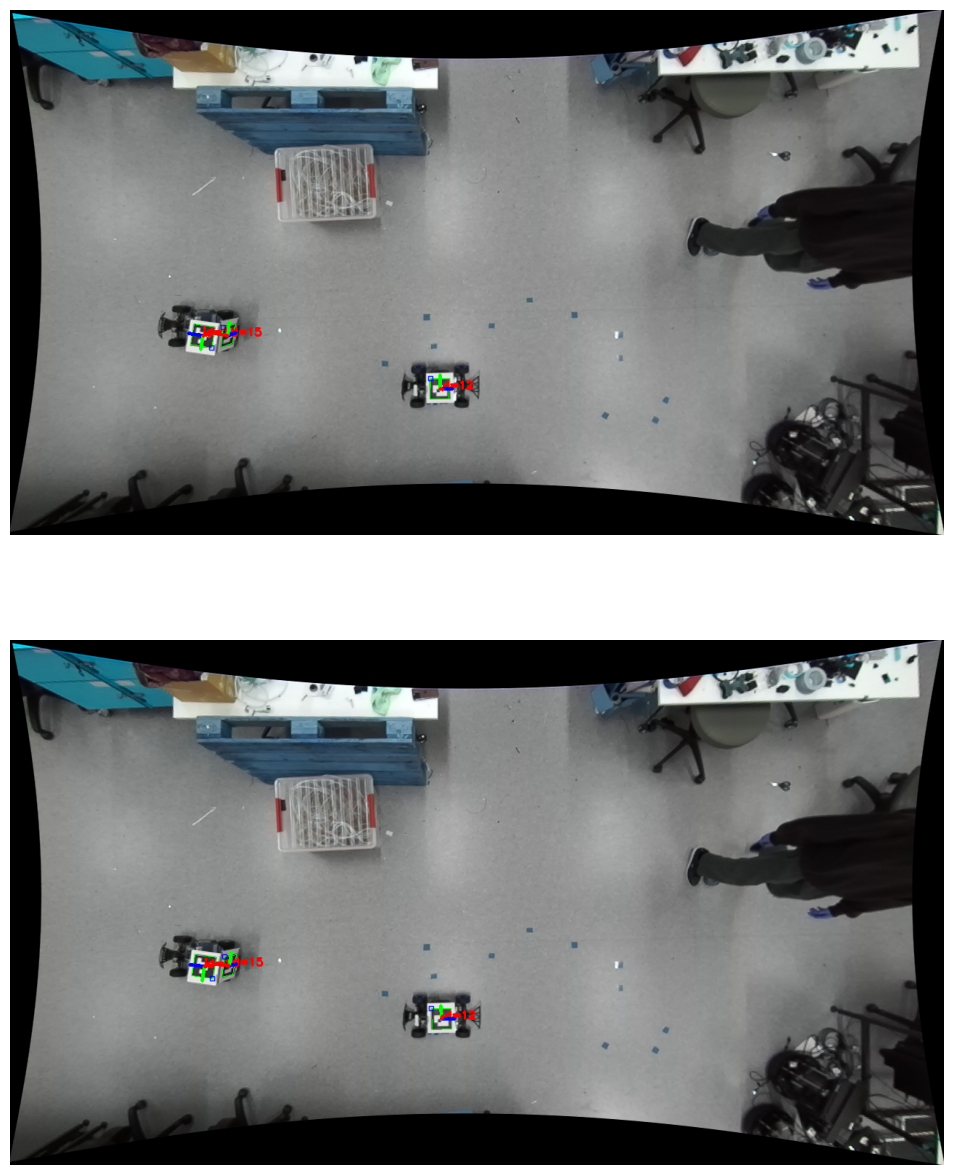

In [20]:
import perception.util.aruco as aruco

num = 174
image_prev = cv2.imread(f'{run1_data[run_num]["bev_path"]}/bev/right/{ego_bev_df["time"].iloc[num - 1]}.png')

image = cv2.imread(f'{run1_data[run_num]["bev_path"]}/bev/right/{ego_bev_df["time"].iloc[num]}.png')
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

intrinsics = np.loadtxt(f'{run1_data[run_num]["bev_path"]}/bev/right/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run1_data[run_num]["bev_path"]}/bev/right/dist_coeffs.txt')

def draw_markers_on_image(image, intrinsics, dist_coeffs):
  new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
  undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)

  und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)

  drawn_image = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)

  for corner, id in zip(und_corners, und_ids):
    _, rvecs_und, tvecs_und, reproj_error = cv2.solvePnPGeneric(marker_obj_points, corner, new_intrinsics, None, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    for rvec_und, tvec_und in zip(rvecs_und, tvecs_und):
      quat = conv.get_quaternion_from_rodrigues(rvec_und)
      euler_und = conv.get_euler_from_quaternion(*quat, degrees=True)
      print(id, euler_und, rvec_und, quat)
    
    print("")
    cv2.drawFrameAxes(drawn_image, new_intrinsics, None, rvec_und, tvec_und, 0.1)
  
  return drawn_image

drawn_image = draw_markers_on_image(image, intrinsics, dist_coeffs)
drawn_image_prev = draw_markers_on_image(image_prev, intrinsics, dist_coeffs)

plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(drawn_image)

plt.subplot(2, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(drawn_image_prev)

In [66]:
z_tx: pd.Series = stats.zscore(ego_bev_df['tx'])
z_tx = z_tx.apply(lambda x: abs(x))

z_ty: pd.Series = stats.zscore(ego_bev_df['ty'])
z_ty = z_ty.apply(lambda x: abs(x))

z_tz: pd.Series = stats.zscore(ego_bev_df['tz'])
z_tz = z_tz.apply(lambda x: abs(x))

# get all the unique indexes of the outliers
outliers = pd.concat((z_tx[z_tx > 3], z_ty[z_ty > 3], z_tz[z_tz > 3])).index.unique()
ego_bev_df.iloc[outliers]

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
0,1726384402093541268,-0.964676,-0.250001,0.081297,0.017074,-2.998112,-0.776977,0.252662,186.205570,40.667059,-9.441644,1.726384e+09,-0.000486,184.267471,8.529174,29.376135
1,1726384402110360820,-0.964873,-0.252454,0.071392,0.013807,-3.004879,-0.786211,0.222335,186.198632,40.661908,-9.456113,1.726384e+09,0.016333,183.625458,7.515688,29.563106
2,1726384402127258873,-0.964307,-0.252401,0.078759,0.014237,-3.002306,-0.785833,0.245211,186.204699,40.666422,-9.443437,1.726384e+09,0.033231,183.895136,8.320421,29.618877
3,1726384402144682550,-0.964664,-0.252273,0.074827,0.013486,-3.004835,-0.785805,0.233079,186.200785,40.663465,-9.451734,1.726384e+09,0.050655,183.691580,7.906760,29.566051
4,1726384402162198248,-0.964829,-0.251753,0.074423,0.013654,-3.005033,-0.784103,0.231797,186.198669,40.661793,-9.456121,1.726384e+09,0.068171,183.693816,7.859071,29.502031
5,1726384402181509645,-0.964903,-0.252357,0.071158,0.014679,-3.003327,-0.785479,0.221484,186.201583,40.663890,-9.450502,1.726384e+09,0.087482,183.714818,7.464543,29.555691
6,1726384402206642560,-0.964667,-0.254593,0.065283,0.018409,-2.995579,-0.790588,0.202722,186.198230,40.661563,-9.456099,1.726384e+09,0.112615,183.969733,6.694674,29.800873
12,1726384402326929850,-0.968774,-0.244970,0.037105,0.009488,-3.025245,-0.764982,0.115871,186.171084,40.649163,-9.477208,1.726384e+09,0.232902,182.100144,3.855755,28.452094
13,1726384402343702343,0.841972,0.219244,-0.438530,0.225182,2.322303,0.604714,-1.209540,186.208342,40.677894,-9.388768,1.726384e+09,0.249675,160.016364,56.845528,18.297288
180,1726384405127170556,0.976561,-0.006411,-0.005253,0.215081,2.707947,-0.017776,-0.014566,184.612469,40.463648,-9.431142,1.726384e+09,3.033143,155.155450,0.429846,-0.846915


In [67]:
# rotate the rvec 90 degrees anticlockwise around the z axis
def rotate_rvec_90(rvec):
    R = cv2.Rodrigues(rvec)[0]
    R_rot = np.array([
        [0, 1, 0],
        [-1, 0, 0],
        [0, 0, 1]
    ])
    R_rotated = R @ R_rot
    return cv2.Rodrigues(R_rotated)[0]

In [42]:
from numpy.polynomial.polynomial import Polynomial

degree = 10
CONFIDENCE_INTERVAL = 0.95

tx_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['tx'], degree)
ty_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['ty'], degree)
tz_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['tz'], 1)

In [43]:
tz_model.coef

array([ 2.95669578e+00, -2.42429130e-03])

In [44]:
tx_preds = tx_model(ego_bev_df['time_norm (sec)'])
ty_preds = ty_model(ego_bev_df['time_norm (sec)'])
tz_preds = tz_model(ego_bev_df['time_norm (sec)'])

tx_residuals = ego_bev_df['tx'] - tx_preds
ty_residuals = ego_bev_df['ty'] - ty_preds
tz_residuals = ego_bev_df['tz'] - tz_preds

# Standard error of the residuals
tx_se = np.sqrt(sum(tx_residuals ** 2) / (len(tx_residuals) - degree - 1))
ty_se = np.sqrt(sum(ty_residuals ** 2) / (len(ty_residuals) - degree - 1))
tz_se = np.sqrt(sum(tz_residuals ** 2) / (len(tz_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

# (tx_residuals.sum() / (len(tx_residuals) - degree-1))
# tx_se = np.std(tx_residuals)

tx_confidence = z_score * tx_se
ty_confidence = z_score * ty_se
tz_confidence = z_score * tz_se

tx_confidence, ty_confidence, tz_confidence

(0.019255782491731294, 0.018270740355279216, 0.05670819452096364)

<AxesSubplot: xlabel='time_norm (sec)'>

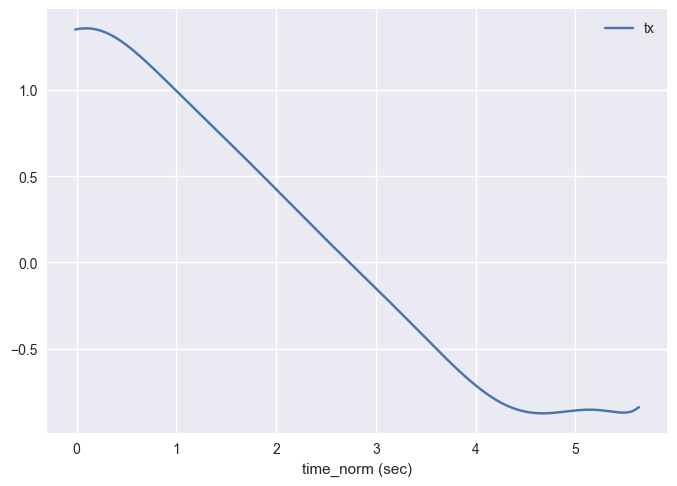

In [34]:
pd.DataFrame(np.vstack((ego_bev_df["time_norm (sec)"].values, tx_preds)).T, columns=["time_norm (sec)", "tx"]).plot(x="time_norm (sec)", y="tx")

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tz'>

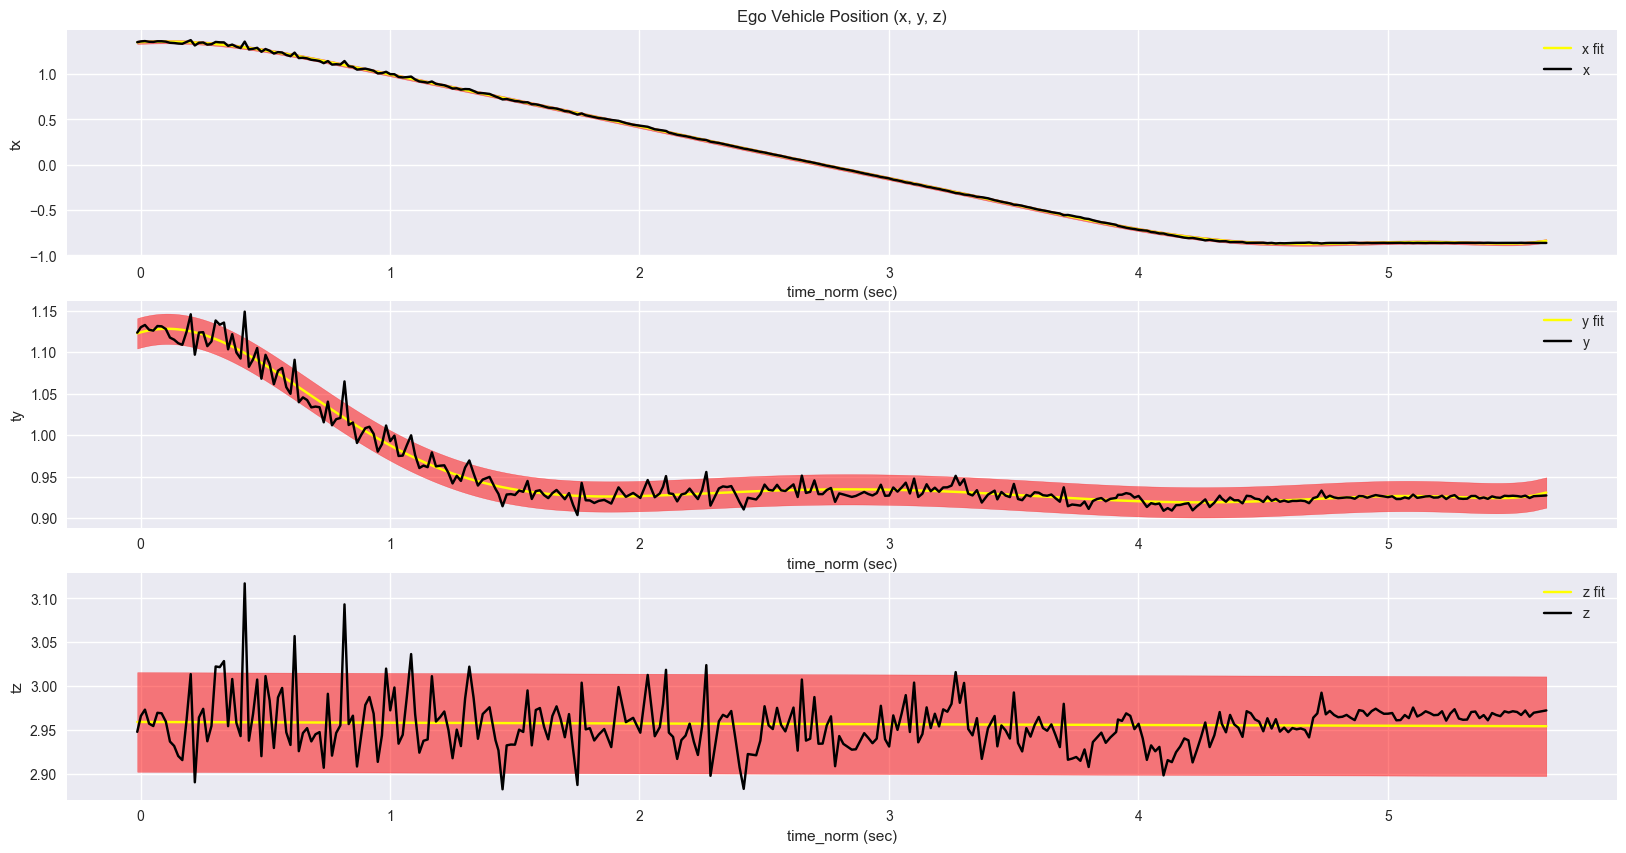

In [41]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Position (x, y, z)')
# plot the polynomial fit
plt.plot(ego_bev_df['time_norm (sec)'], tx_preds, label='x fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_df['time_norm (sec)'], tx_preds - tx_confidence, 
                    tx_preds + tx_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='tx', label='x', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_df['time_norm (sec)'], ty_preds, label='y fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_df['time_norm (sec)'], ty_preds - ty_confidence, 
                 ty_preds + ty_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='ty', label='y', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_df['time_norm (sec)'], tz_preds, label='z fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_df['time_norm (sec)'], tz_preds - tz_confidence, 
                 tz_preds + tz_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='tz', label='z', color='black')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='yaw'>

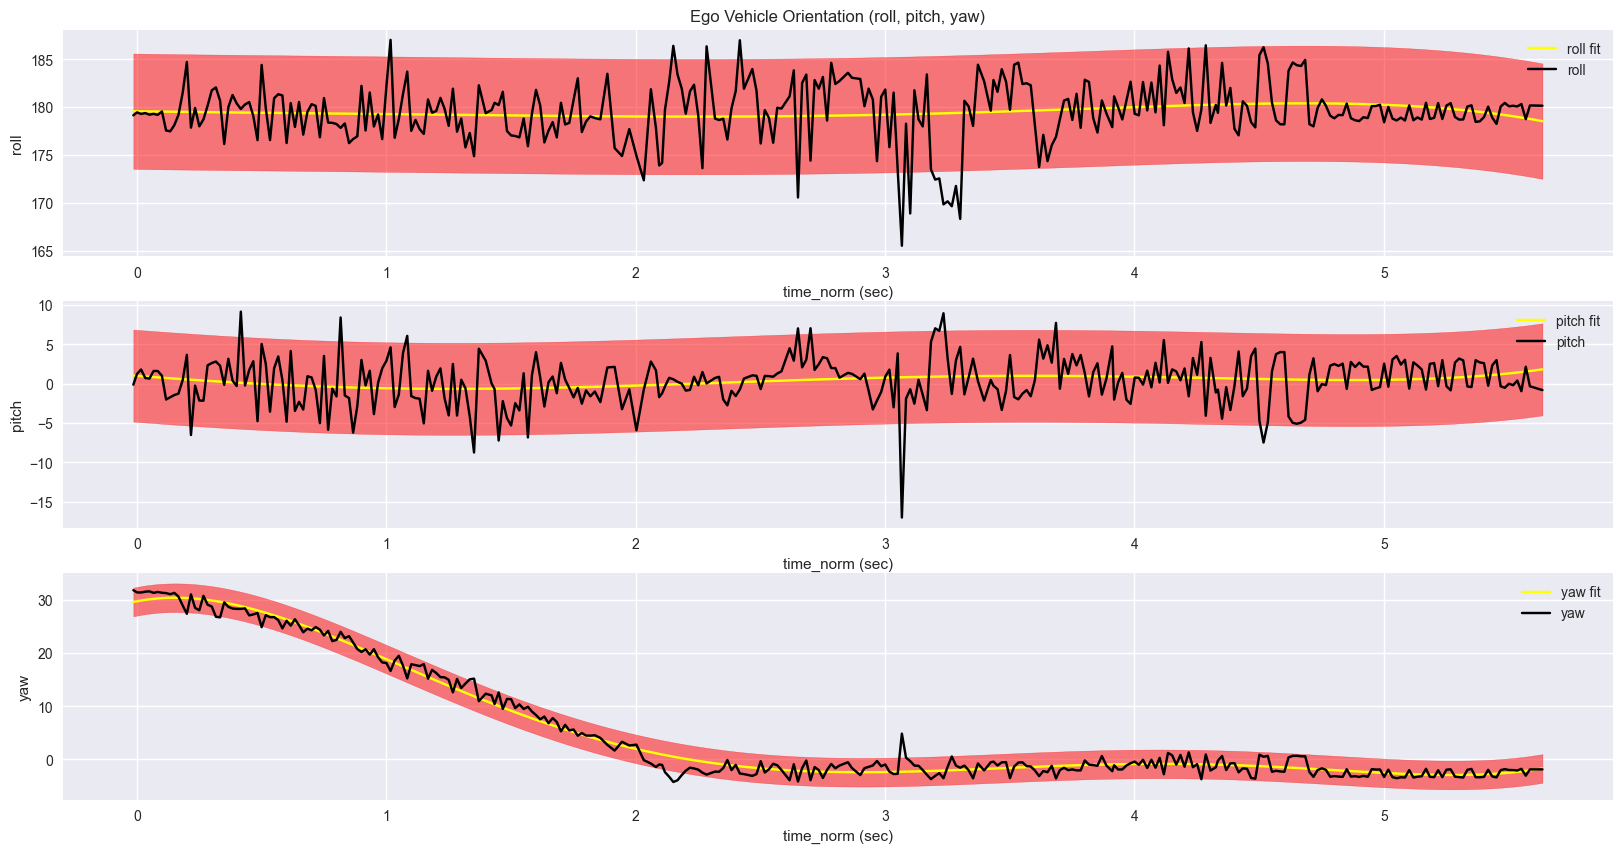

In [25]:
# plot the euler angles of ego_bev_df in the same way
degree = 5
roll_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['roll'], degree)
pitch_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['pitch'], degree)
yaw_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['yaw'], degree)

roll_preds = roll_model(ego_bev_df['time_norm (sec)'])
pitch_preds = pitch_model(ego_bev_df['time_norm (sec)'])
yaw_preds = yaw_model(ego_bev_df['time_norm (sec)'])

roll_residuals = ego_bev_df['roll'] - roll_preds
pitch_residuals = ego_bev_df['pitch'] - pitch_preds
yaw_residuals = ego_bev_df['yaw'] - yaw_preds

roll_se = np.sqrt(sum(roll_residuals ** 2) / (len(roll_residuals) - degree - 1))
pitch_se = np.sqrt(sum(pitch_residuals ** 2) / (len(pitch_residuals) - degree - 1))
yaw_se = np.sqrt(sum(yaw_residuals ** 2) / (len(yaw_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

roll_confidence = z_score * roll_se
pitch_confidence = z_score * pitch_se
yaw_confidence = z_score * yaw_se

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Orientation (roll, pitch, yaw)')
# plot the polynomial fit
plt.plot(ego_bev_df['time_norm (sec)'], roll_preds, label='roll fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_df['time_norm (sec)'], roll_preds - roll_confidence, 
                    roll_preds + roll_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='roll', label='roll', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_df['time_norm (sec)'], pitch_preds, label='pitch fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_df['time_norm (sec)'], pitch_preds - pitch_confidence, 
                 pitch_preds + pitch_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='pitch', label='pitch', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_df['time_norm (sec)'], yaw_preds, label='yaw fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_df['time_norm (sec)'], yaw_preds - yaw_confidence, 
                 yaw_preds + yaw_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='yaw', label='yaw', color='black')

In [26]:
ego_bev_df[ego_bev_df["roll"] < 170]

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
174,1726384505866963320,0.980984,0.022883,0.152042,0.118451,2.869107,0.066926,0.444681,-0.195263,0.942654,2.989663,1.726385e+09,3.067568,165.502861,-17.030487,4.854474
176,1726384505900324580,0.995269,-0.003290,0.006039,0.096915,2.947388,-0.009744,0.017885,-0.213921,0.947519,3.003954,1.726385e+09,3.100930,168.878588,-0.725358,-0.308210
184,1726384506033724738,0.992778,-0.023767,-0.080263,0.085939,2.959003,-0.070837,-0.239225,-0.287236,0.937060,2.970761,1.726385e+09,3.234330,169.828617,8.933101,-3.539351
186,1726384506067070364,0.995836,0.003840,0.011951,0.090299,2.960513,0.011416,0.035530,-0.312208,0.950905,3.015891,1.726385e+09,3.267676,169.631047,-1.324187,0.562025
188,1726384506100723771,0.993942,-0.009397,-0.041794,0.101211,2.936097,-0.027759,-0.123460,-0.329185,0.946816,3.003576,1.726385e+09,3.301329,168.307975,4.656394,-1.560387


In [ ]:
ego_bev_df["roll"]